0.999315537303217
4.632800608828007
[0.0, 0.12822827157509362, 0.25645654315018723, 0.38468481472528077, 0.5129130863003745, 0.641141357875468, 0.7693696294505615, 0.8975979010256553, 1.025826172600749, 1.1540544441758425, 1.282282715750936, 1.4105109873260295, 1.538739258901123, 1.6669675304762166, 1.7951958020513106, 1.9234240736264039, 2.051652345201498, 2.179880616776591, 2.308108888351685, 2.4363371599267785, 2.564565431501872, 2.6927937030769655, 2.821021974652059, 2.949250246227153, 3.077478517802246, 3.20570678937734, 3.333935060952433, 3.4621633325275276, 3.590391604102621, 3.7186198756777142, 3.8468481472528078, 3.975076418827901, 4.103304690402996, 4.231532961978089, 4.359761233553182, 4.487989505128276, 4.61621777670337, 4.744446048278463, 4.872674319853557, 5.00090259142865, 5.129130863003744, 5.257359134578838, 5.385587406153931, 5.513815677729024, 5.642043949304118, 5.770272220879212, 5.898500492454306, 6.026728764029399, 6.154957035604492, 6.283185307179586]
4.629629629

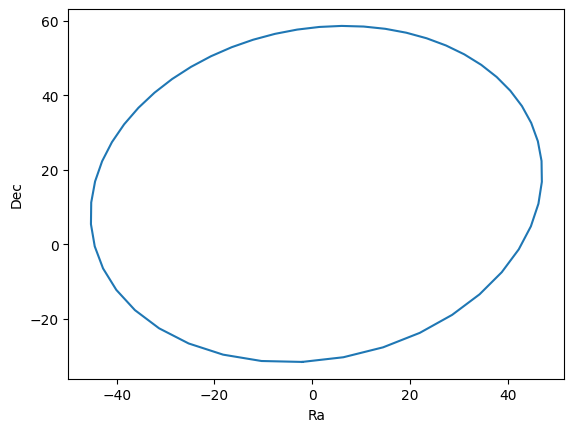

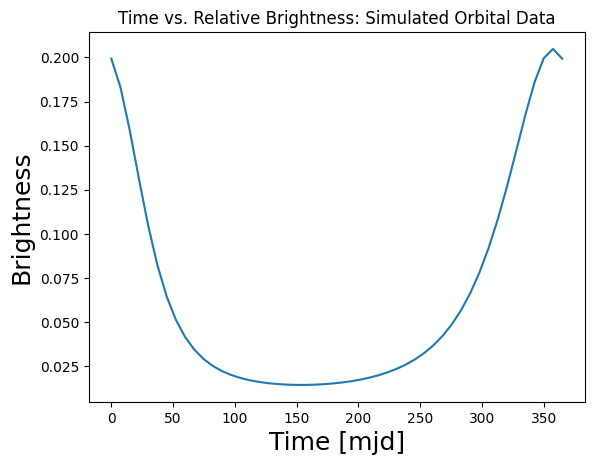

In [20]:
# Toy Model: Converting orbital elements to position
import numpy as np
import math
import matplotlib.pyplot as plt
from astropy.time import Time
from astropy import units as u, constants as cst

# orbit values
r = 50 # projected sma [mas]
e = 0.3
inc = np.radians(30) # [radians]
Omega = np.radians(60) # [radians]
omega = np.radians(120) # [radians]
plx = 30 # [mas]
albedo= 0.5
tau_ref_epoch = 0 # [mjd]
T = 365 # [days]
T_yr = (T*u.day).to(u.yr).value
print(T_yr)
t0 = 0

# the semimajor axis (a) that is implied here is r / plx = 5/3 au
sma = r/plx # [au]
Mtot = sma**3 / T_yr
print(Mtot)

# First define functions:

#Here will be the function where we convert time to mean anomaly; we will convert these 5 values:
# time_values = np.linspace(0, 1, num=50) # [time_values are in years]
time_values = Time(np.linspace(0, 365, num=50), format='mjd')

# We can begin defining the conversion and its variables
# t0 is time since periapsis (when its closest to the star) (years), t is the current time, T is orbital period (in years), a is semi-major axis (in au)
def time_to_mean_anomaly(t, t0, T):
   

# This is the equation to go from time to mean anomaly
   mean_anomaly = (2 * math.pi * (((t-t0)/T) - tau_ref_epoch))
   return mean_anomaly
    


mean_anomalies = []
for i in time_values.mjd:
    mean_anomaly = time_to_mean_anomaly(i, t0, T)
    mean_anomalies.append(mean_anomaly)

print(mean_anomalies)

# print out the final answer as a statement
#for i, mean_anomaly in enumerate(mean_anomalies):
    #print(f"Time: {time_values[i]} degrees --> Mean Anomaly: {math.degrees(mean_anomaly)} degrees --> Eccentric Anomaly: {math.degrees(Ecc_anomalies_list[i])} degrees")


# Define mean anomaly to eccentric anomaly
def mean_to_eccentric(mean_anomaly, e):
    #Here is where we convert from mean anomaly to eccentric anomanly
    E = mean_anomaly

# Solution to keplers equation is below: M = E - e * sin(E), which turns into f(E) = M + e *sin(E)
    max_iterations = 50
    tolerance = 1e-9

    for _ in range(max_iterations):

        E_new = E - (E - e * np.sin(E) - mean_anomaly) / (1 - e * np.cos(E))
        if abs(E_new - E) < tolerance:
            break
        E = E_new
        

    return E
Ecc_anomalies_list = []
for i in mean_anomalies:
    E =  mean_to_eccentric(i,e)
    Ecc_anomalies_list.append(E)
#print("These are the eccentric anomalies:", Ecc_anomalies_list)

# Convert from eccentric anomaly to true anomaly
def eccentric_to_true(E, e):

# Calculate tan(f/2)
    tan_f_over_2 = math.sqrt((1 + e) / (1 - e)) * math.tan(E / 2)
    
    # Calculate ν
    f = 2 * math.atan(tan_f_over_2)
    
    #make sure nu is within [0, 2π)
    if f < 0:
        f += 2 * math.pi
    
    return f
true_anomalies = []
for i in Ecc_anomalies_list:
    f = eccentric_to_true(i, e)
    true_anomalies.append(f)
#print("These are the true anomalies:", true_anomalies)

#print("These are the orbital positions:", orbital_elements_and_true_anomaly_to_positions)

def orbital_elements_and_true_anomaly_to_positions(f, eanom, r, e,inc, Omega, omega, plx, albedo):
    # Write the converting function
    # ra & dec should be in units of milliarcseconds (mas)
    # r should also be mas
    # Omega, omega, f, and inc should all be in radians.
    sma = r/plx

    radius = sma * (1.0 - e * np.cos(eanom))

    # ra/dec math copied from orbitize
    c2i2 = np.cos(0.5*inc)**2
    s2i2 = np.sin(0.5*inc)**2
    arg1 = f + omega + Omega
    arg2 = f + omega - Omega
    c1 = np.cos(arg1)
    c2 = np.cos(arg2)
    s1 = np.sin(arg1)
    s2 = np.sin(arg2)

    ra = radius * (c2i2*s1 - s2i2*s2) * plx
    dec = radius * (c2i2*c1 + s2i2*c2) * plx

    r_in_arcsec = r * 1e-3
    plx_in_arcsec = plx * 1e-3
    dist = 1/plx_in_arcsec # [pc]

    a = dist*r_in_arcsec # [au]

    # a**3 = per**2 * Mtot

    print(a**3) # this is the total mass
    
    R = (a*(1-e**2))/(1+e*np.cos(f))
        
    z = R*(-np.cos(omega)*np.sin(inc)*np.sin(f)-np.cos(f)*np.sin(inc)*np.sin(omega))
        
    ro = (z**2+((ra**2+dec**2)/plx**2))**0.5
        
    B = math.atan2(-ro, z)+ math.pi
        
    A = (1/math.pi)*(np.sin(B)+(math.pi-B)*np.cos(B))
        
    brightness = albedo*A/ro**2
        
    return ra, dec, brightness


oe_to_pos_ra = []
oe_to_pos_dec = []
brightness_new = []
for i, f in enumerate(true_anomalies):
    ecc_anom = Ecc_anomalies_list[i]
    ra, dec, brightness = orbital_elements_and_true_anomaly_to_positions(f, ecc_anom, r, e, inc, Omega, omega, plx, albedo)

    oe_to_pos_ra.append(ra)
    oe_to_pos_dec.append(dec)
    brightness_new.append(brightness)

#print("These are the true anomalies:", true_anomalies)

#print("These are the orbital positions:", orbital_elements_and_true_anomaly_to_positions)

#print("These are the orbital positions!", oe_to_pos)

# print out the final answer as a statement
#for i, mean_anomaly in enumerate(mean_anomalies):
    #print(f"Time: {time_values[i]} degrees --> Mean Anomaly: {math.degrees(mean_anomaly)} degrees --> Eccentric Anomaly: {math.degrees(Ecc_anomalies_list[i])} degrees")

# Now lets plot the ra and dec values
#print(oe_to_pos_ra)
#print(oe_to_pos_dec)

plt.figure()
plt.plot(oe_to_pos_ra, oe_to_pos_dec)
plt.xlabel('Ra')
plt.ylabel('Dec')

plt.figure()
plt.plot(time_values.mjd, brightness_new)
plt.xlabel("Time [mjd]", fontsize=18)
plt.ylabel("Brightness", fontsize=18)
plt.title("Time vs. Relative Brightness: Simulated Orbital Data")

import csv

# Assuming you already have ra, dec, brightness, and time (as epoch)
# oe_to_pos_ra, oe_to_pos_dec, brightness_new, and time_values lists exist

#CSV file name
#filename = "/Users/farrahamolina/orbitize/orbitize/example_data/orbital_data_with_id.csv"
# filename = "/Users/farrahamolina/orbitize/orbitize/example_data/simulated_ra_dec_data.csv"
filename = "simulated_ra_dec_data.csv"
Object_ID_List = [1] * 50
raoff_err_list = [0.01] * 50
decoff_err_list = [0.01] * 50

#with open(filename, mode='w', newline='') as file:
 #   writer = csv.writer(file)

    # Write the header with the additional "object_id" column
  #  writer.writerow(["epoch", "object", "raoff", "decoff", "raoff_err", "decoff_err", "brightness"])

    # Write the data rows with a unique ID for each object
   # for (epoch, obj, ra, dec, raoff_err, decoff_err, brightness) in (zip(time_values, Object_ID_List, oe_to_pos_ra, oe_to_pos_dec, raoff_err_list, decoff_err_list,  brightness_new)):
    #    writer.writerow([epoch, obj, ra, dec, raoff_err,decoff_err, brightness])

#print("csv file success!!")

with open(filename, mode='w', newline='') as file:
    writer = csv.writer(file)

    # Write the header with the additional "object_id" column
    writer.writerow(["epoch", "object", "raoff", "decoff", "raoff_err", "decoff_err"])

    # Write the data rows with a unique ID for each object
    for (epoch, obj, ra, dec, raoff_err, decoff_err) in (zip(time_values, Object_ID_List, oe_to_pos_ra, oe_to_pos_dec, raoff_err_list, decoff_err_list)):
        writer.writerow([epoch.mjd, obj, ra, dec, raoff_err,decoff_err])

print("simulated data csv success!")